# Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
import os
from sklearn.datasets import load_sample_image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image

from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, Dropout, BatchNormalization

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

# Extract, Transform, Load

In [ ]:
Siraton_Roei = '/content/drive/MyDrive/Beetle_Data/Siraton_Roei_Formatted/'
Siraton_Internatus = '/content/drive/MyDrive/Beetle_Data/Siraton_Internatus_Formatted/'
Demyrsus_Meleoides = '/content/drive/MyDrive/Beetle_Data/Demyrsus_Meleoides_Formatted/'
Demyrsus_Digmon = '/content/drive/MyDrive/Beetle_Data/Demyrsus_Digmon_Formatted/'

Other_Beetle = '/content/drive/MyDrive/Beetle_Data/Others/insect_database/beetle_combined/'
Tiger_Beetle = '/content/drive/MyDrive/Beetle_Data/Others/insect_database/tiger_beetle/'
More_Beetle = '/content/drive/MyDrive/Beetle_Data/Others/insect_database/more_beetle_simple_background/'

In [ ]:
def image_process(file_path):
  read_file = tf.io.read_file(file_path)
  image = tf.image.decode_image(read_file)
  return image

In [ ]:
def make_dataset(path_ls):
  dataset_polished = []
  for path in path_ls:
    dataset = tf.data.Dataset.list_files(f'{path}*', seed = 42)
    for each in dataset:
      read_file = tf.io.read_file(each)
      image = tf.image.decode_image(read_file)
      if len(image.shape) == 3 and image.shape[-1] == 3:
        dataset_polished.append(each)

  dataset_polished_shuffled = tf.random.shuffle(dataset_polished)
  dataset_sliced = tf.data.Dataset.from_tensor_slices(dataset_polished_shuffled)
  dataset_images = dataset_sliced.map(image_process)
  return dataset_images

In [ ]:
siraton_images = make_dataset([Siraton_Roei, Siraton_Internatus])
len(siraton_images)

163

In [ ]:
demyrsus_images = make_dataset([Demyrsus_Meleoides, Demyrsus_Digmon])
len(demyrsus_images)

128

In [ ]:
other_beetle_images = make_dataset([Other_Beetle])
len(other_beetle_images)


201

In [ ]:
N_TRAIN = 90
N_VAL = 18
N_TEST = 20

N_CLASSES = 2

In [ ]:
def train_val_test_split(Images, N_TRAIN=100, N_VAL=18, N_TEST=10):
  Train_Set = Images.take(N_TRAIN)

  Val_Set = Images.skip(N_TRAIN)
  Val_Set = Val_Set.take(N_VAL)

  Test_Set = Images.skip(N_TRAIN+N_VAL)
  Test_Set = Test_Set.take(N_TEST)

  return Train_Set, Val_Set, Test_Set

In [ ]:
siraton_train, siraton_val, siraton_test = train_val_test_split(siraton_images, N_TRAIN, N_VAL, N_TEST)

In [ ]:
demyrsus_train, demyrsus_val, demyrsus_test = train_val_test_split(demyrsus_images, N_TRAIN, N_VAL, N_TEST)

In [ ]:
other_beetle_train, other_beetle_val, other_beetle_test = train_val_test_split(other_beetle_images, N_TRAIN, N_VAL, N_TEST)

In [ ]:
def preprocess_img(image):
  image = np.squeeze(image)
  h, w, c = image.shape
  h_new, w_new = h, w
  if w >= h:
    aspect_ratio = w/h
    h_new = 384
    w_new = int(h_new*aspect_ratio)
  else:
    aspect_ratio = h/w
    w_new = 384
    h_new = int(w_new*aspect_ratio)
  resized_img = tf.keras.preprocessing.image.smart_resize(image, size=[h_new, w_new])

  return resized_img

In [ ]:
def make_dataset_ls(sets, type):
  data = []
  labels = []
  
  n = 0
  for dataset in sets:
    for img in dataset:
      processed_img = preprocess_img(img)
      
      if type == 'train':
        data.append(processed_img)
      elif type == 'val' or type == 'test':
        center_cropped_img = tf.keras.preprocessing.image.smart_resize(img, size=[384, 384])
        data.append(center_cropped_img)

      labels.append(n)
    n += 1

  return data, np.array(labels)

In [ ]:
train_x, train_y = make_dataset_ls([siraton_train, demyrsus_train, other_beetle_train], 'train')
val_x, val_y = make_dataset_ls([siraton_val, demyrsus_val, other_beetle_val], 'val')
test_x, test_y = make_dataset_ls([siraton_test, demyrsus_test, other_beetle_test], 'test')


In [ ]:
train_y.shape

(270,)

In [ ]:
NUM_CLASSES = 3
train_y_one_hot = tf.one_hot(train_y, depth = NUM_CLASSES)
val_y_one_hot = tf.one_hot(val_y, depth = NUM_CLASSES)

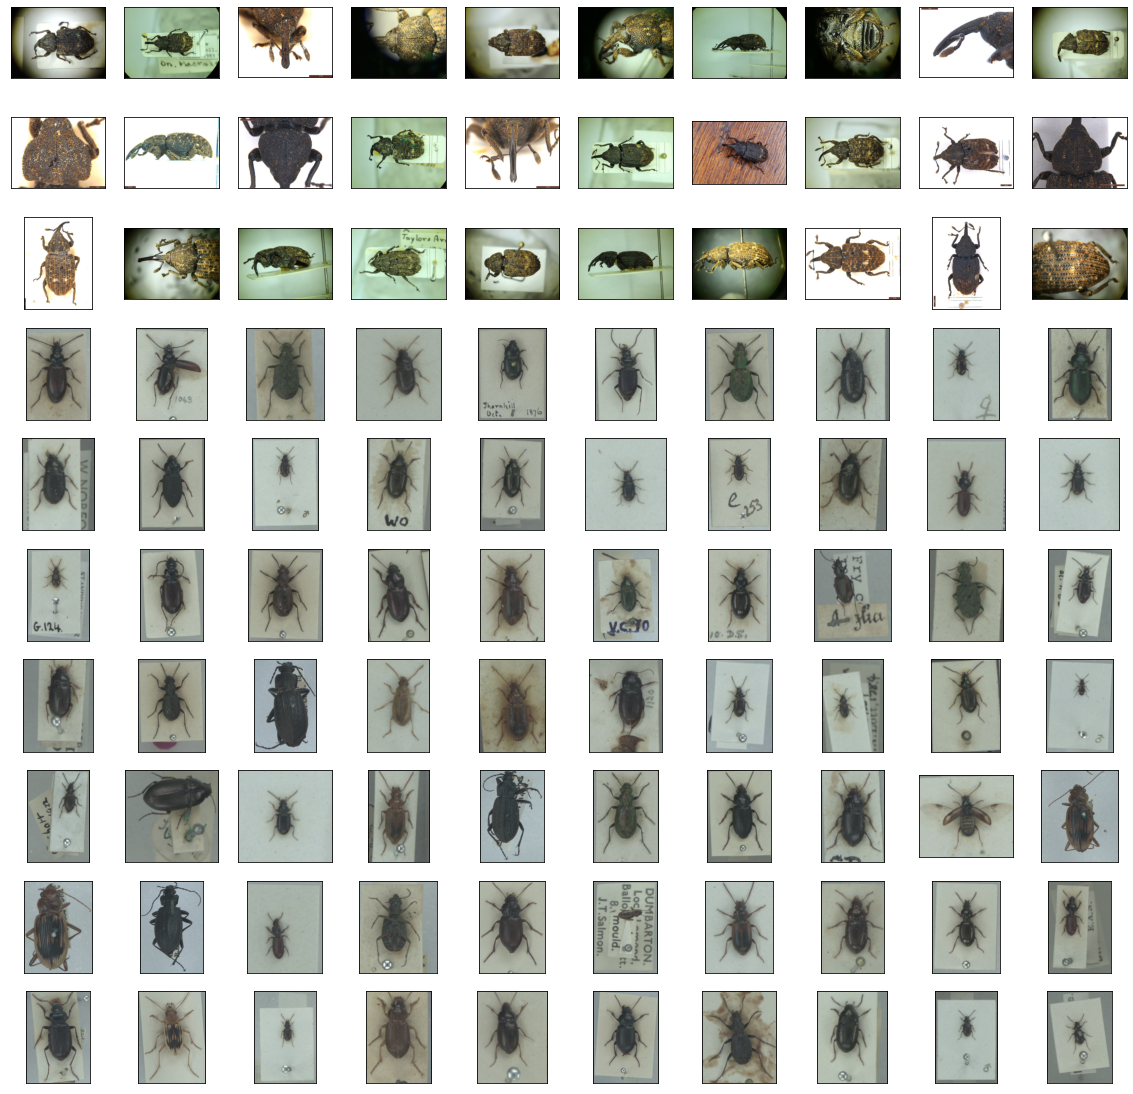

In [ ]:
plt.figure(figsize=(20,20))
for i, image in enumerate(train_x[150:250]):
  plt.subplot(10,10,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image/255)
plt.show()

# Data Augmentation

In [ ]:
def data_augmentation(x, y):
  augmentation_dict = {
      0: layers.RandomFlip("vertical"),
      1: layers.RandomZoom(0.5),
      2: layers.RandomRotation(0.35),
      3: layers.RandomTranslation(height_factor=0.3, width_factor=0, fill_mode='constant'),
      4: layers.RandomTranslation(height_factor=0, width_factor=0.3, fill_mode='constant'),
      5: layers.RandomFlip("horizontal")
  }

  augmented_x_ls = []
  augmented_y_ls = []

  for n in range(7):
    augment_combination = tf.random.uniform(shape=(len(augmentation_dict),), minval=0, maxval=2, dtype=tf.int32) 
    
    augment_index = []
    for i, each in enumerate(augment_combination):
      if each == 1:
        augment_index.append(i)

    augmentation_sequence = tf.keras.Sequential()
    # random crop 
    augmentation_sequence.add(tf.keras.layers.RandomCrop(384, 384))

    # add augmentation
    for index in augment_index: 
      augmentation_sequence.add(augmentation_dict[index])

    augmented_x = augmentation_sequence(x)
    augmented_x_ls.append(augmented_x)
    augmented_y_ls.append(tf.identity(y))

  return tf.stack(augmented_x_ls, axis=0), tf.stack(augmented_y_ls, axis=0)

In [ ]:
def data_augmentation_all(all_x, all_y):
  all_x_augmented, all_y_augmented = [], []
  for i, x in enumerate(all_x):
    x_augmented, y_augmented = data_augmentation(x, all_y[i])
    all_x_augmented.append(x_augmented)
    all_y_augmented.append(y_augmented)
  return tf.concat(all_x_augmented, axis = 0), tf.concat(all_y_augmented, axis=0)

In [ ]:
train_x_augmented, train_y_augmented = data_augmentation_all(train_x, train_y_one_hot)

# Visualise data augmentation

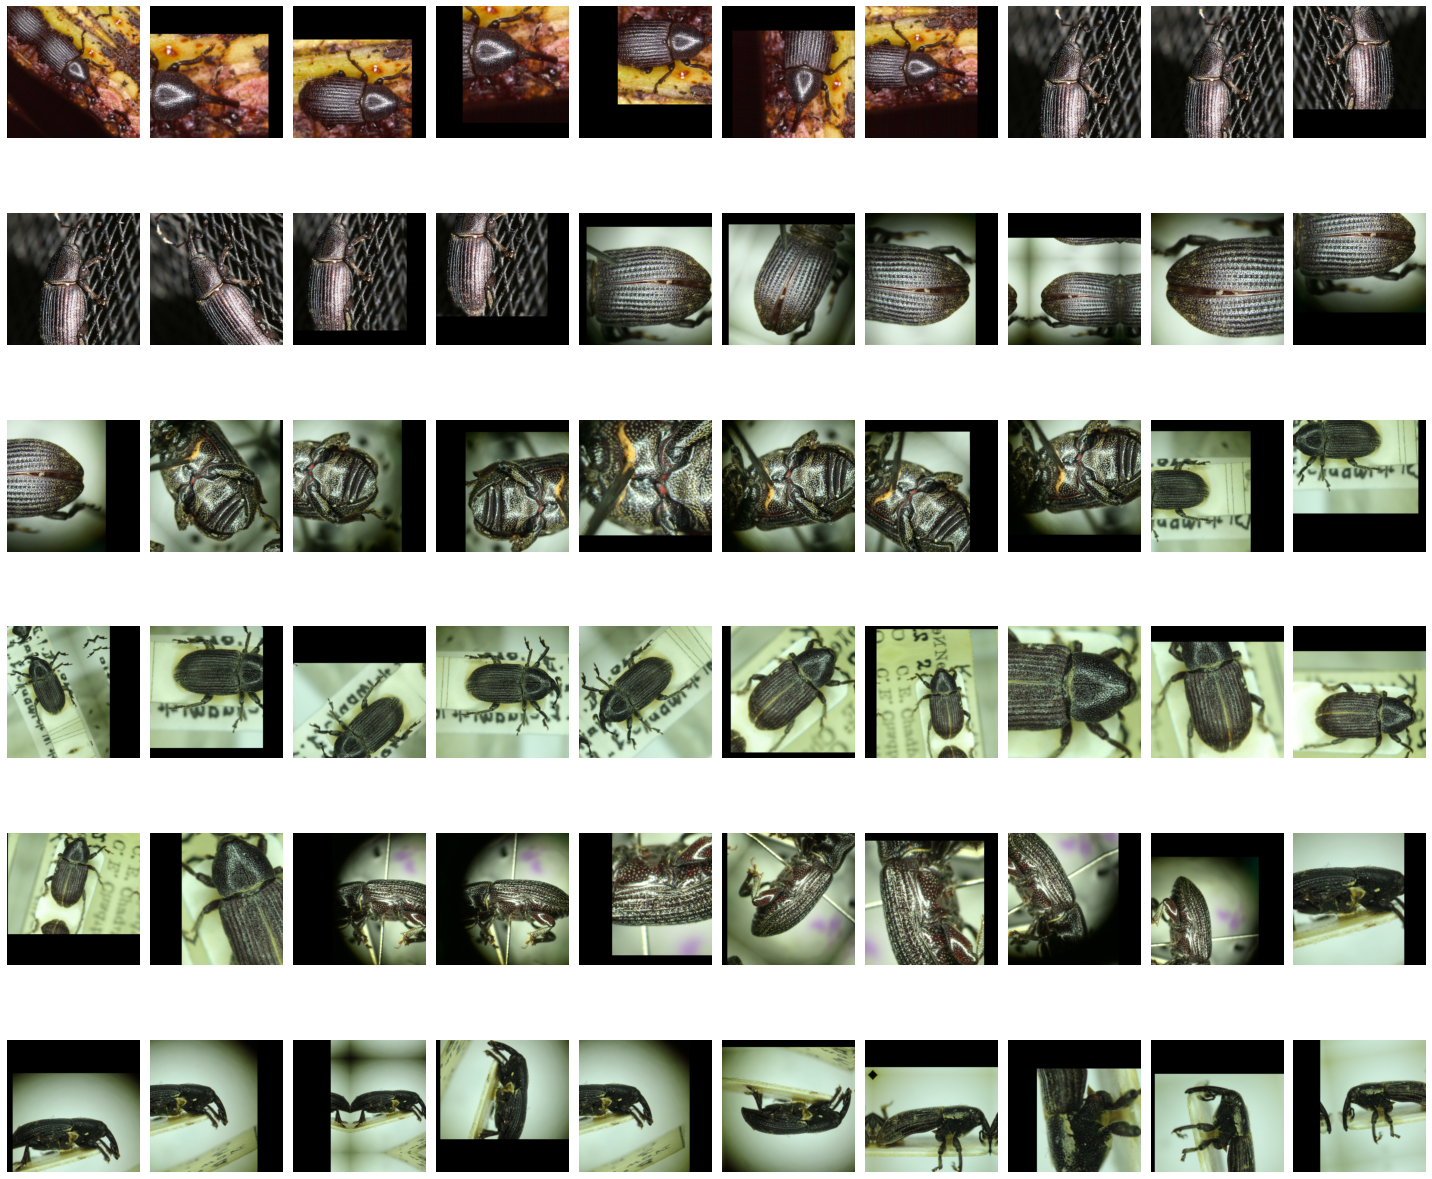

In [ ]:
nrows = 6
ncols = 10
fig, axs = plt.subplots(nrows, ncols, figsize = (ncols*2, nrows*3))

n = 0
for i in range(nrows):
  for j in range(ncols):

    axs[i,j].imshow(train_x_augmented[n]/255)

    axs[i,j].axis('off')
    n += 1
plt.tight_layout()
plt.show()

In [ ]:
val_data_label = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(val_x), 
                                      tf.data.Dataset.from_tensor_slices(val_y_one_hot)))
val_data = val_data_label.shuffle(buffer_size = 50).batch(18) 

In [ ]:
train_data_augmented = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(train_x_augmented),
                                            tf.data.Dataset.from_tensor_slices(train_y_augmented)))
train_data = train_data_augmented.shuffle(buffer_size = 2000).batch(16) 

# Pretrained Resnet 50

In [ ]:
def feature_extractor(inputs):
  
  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(384, 384, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

In [ ]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)

    x = tf.keras.layers.Flatten()(x)
    x = Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    
    x = tf.keras.layers.Dense(3, activation="softmax", name="classification")(x)
    return x

In [ ]:
def final_model(inputs):

    preprocessed_input = tf.keras.applications.resnet50.preprocess_input(inputs)
    resnet_feature_extractor = feature_extractor(preprocessed_input)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

In [ ]:
def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(384,384,3))

    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
    opt = Adam(learning_rate=0.00001)#, clipnorm=1.0)
    model.compile(optimizer=opt, 
                loss='binary_crossentropy',
                metrics = ['accuracy'])

    return model


model = define_compile_model()

model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 384, 384, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 384, 384, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 12, 12, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                              

In [ ]:
history = model.fit(train_data, validation_data=(val_data), 
                   epochs=25)

Epoch 1/25
119/119 [==============================] - 39s 169ms/step - loss: 0.3415 - accuracy: 0.8222 - val_loss: 0.0977 - val_accuracy: 0.9444
Epoch 2/25
119/119 [==============================] - 17s 145ms/step - loss: 0.0969 - accuracy: 0.9704 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 3/25
119/119 [==============================] - 17s 145ms/step - loss: 0.0509 - accuracy: 0.9820 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 4/25
119/119 [==============================] - 18s 149ms/step - loss: 0.0278 - accuracy: 0.9952 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 5/25
119/119 [==============================] - 18s 152ms/step - loss: 0.0193 - accuracy: 0.9952 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 6/25
119/119 [==============================] - 18s 152ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 7/25
119/119 [==============================] - 18s 153ms/step - loss: 0.0102 - accuracy: 0.9984 - val_loss: 0.0011 - val_ac

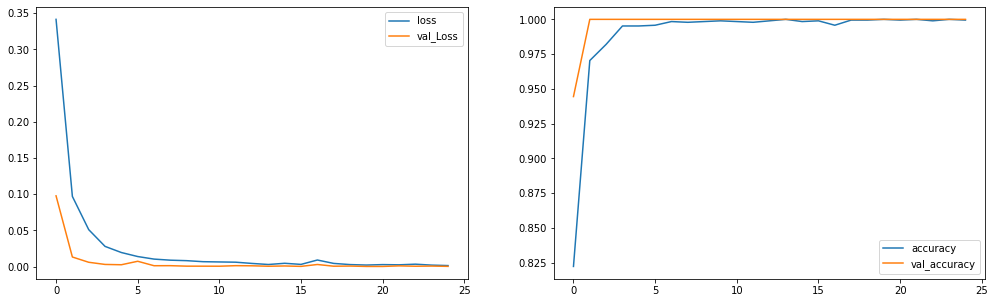

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(17, 5))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].legend(['loss', "val_Loss"])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].legend(['accuracy', "val_accuracy"])

plt.show()

In [ ]:
test_pred = model.predict(np.array(test_x))
test_predicted_label = np.argmax(test_pred, axis = 1)

In [ ]:
# test accuracy
np.sum(test_predicted_label == test_y) / len(test_y)

0.9833333333333333

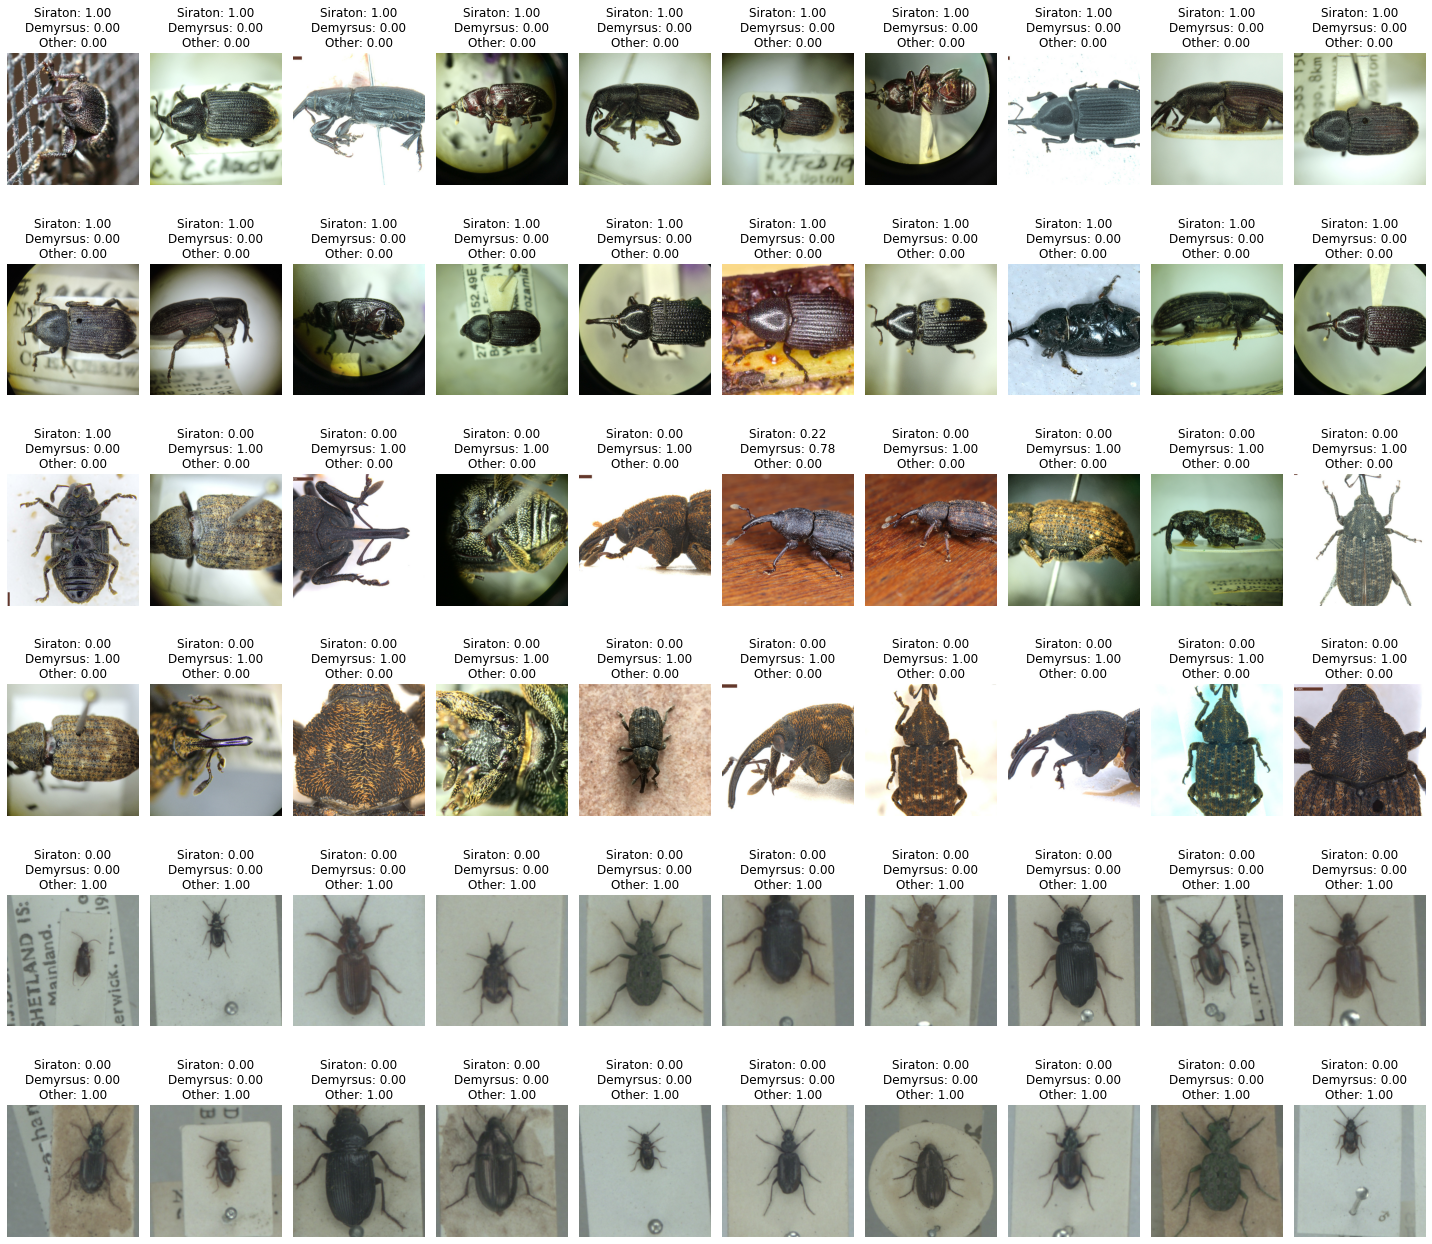

In [ ]:
nrows = 6
ncols = 10
fig, axs = plt.subplots(nrows, ncols, figsize = (ncols*2, nrows*3))

n = 0
for i in range(nrows):
  for j in range(ncols):
    # prob1, prob2, prob3, prob4 = test_pred[n]
    prob1, prob2, prob3 = test_pred[n]
    
    axs[i,j].imshow(test_x[n]/255)
    axs[i,j].set_title('Siraton: {:.2f}\nDemyrsus: {:.2f}\nOther: {:.2f}'.format(prob1, prob2, prob3))
    
    axs[i,j].axis('off')
    n += 1
plt.tight_layout()
plt.show()

# Unseen data

In [ ]:
test_data_path = '/content/drive/MyDrive/Beetle_Data/Test_Data/'
test_data = make_dataset([test_data_path])

In [ ]:
test_data

<MapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None)>

In [ ]:
test_data_ls = []
for image in test_data:
  center_cropped_img = tf.keras.preprocessing.image.smart_resize(image, size=[384, 384])
  test_data_ls.append(center_cropped_img)
test_data_ls = np.array(test_data_ls)

In [ ]:
test_data_pred = model.predict(test_data_ls)

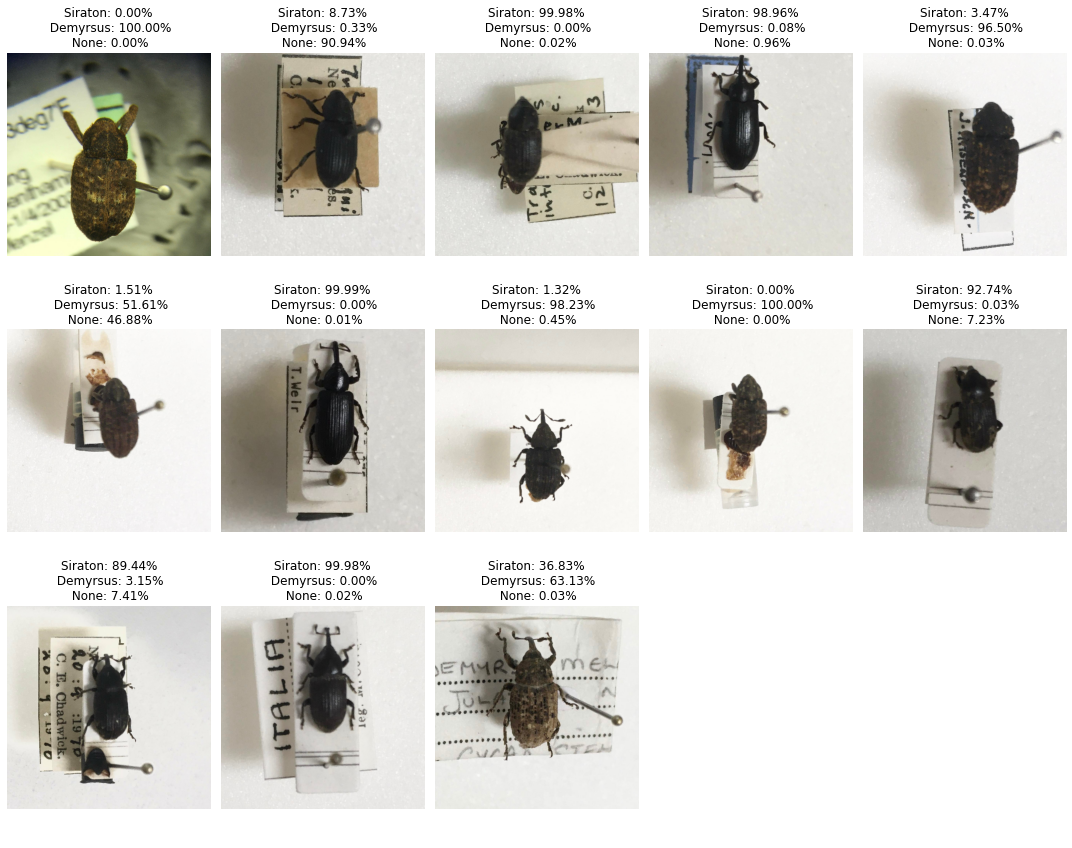

In [ ]:
ncolumns = 5
nrows = 3
fig, axs = plt.subplots(nrows, ncolumns, figsize=(ncolumns*3,nrows*4))

n = 0
for i in range(nrows):
  for j in range(ncolumns):
    try:
      axs[i,j].imshow(test_data_ls[n]/255)

      # 3 classes
      siraton_prob, demyrsus_prob, not_prob = test_data_pred[n]*100
      result = 'Siraton: {:.2f}%\n Demyrsus: {:.2f}%\n None: {:.2f}%'.format(siraton_prob, demyrsus_prob, not_prob)
      
      axs[i,j].set_title(result)
      
    except IndexError:
      pass
    finally:
      axs[i,j].axis('off')
      n += 1
plt.tight_layout()
plt.show()


In [48]:
model.save('/content/drive/MyDrive/Colab Notebooks/Beetle/Other Beetle None Class/bfs_or_not_paper_data') 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Beetle/Other Beetle None Class/bfs_or_not_paper_data/assets
